In [124]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# Imports for logistic Regression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

import os
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

In [2]:
%reload_ext google.cloud.bigquery

In [3]:
%%bigquery
SELECT
    COUNT(DISTINCT(unique_pid))
FROM
    playlist_songs.playlists;


,f0_
0,909100


In [4]:
%%bigquery
SELECT
    COUNT(unique_pid)
FROM
    playlist_songs.playlists;

,f0_
0,66346428


1. Get all tracks from random list of 1000 playlists. The limiting dimension is the playlist.
2. Train test split the data

In [77]:
%%bigquery playlist_tracks
SELECT
    ps.unique_pid, 
    ps.artist_name, 
    ps.track_name, 
    ps.album_name, 
    th.trackid,
    th.danceability,
    th.energy,
    th.key,
    th.loudness,
    th.mode,
    th.speechiness,
    th.acousticness,
    th.instrumentalness,
    th.liveness,
    th.valence,
    th.tempo,
    th.duration_ms,
    th.time_signature
FROM
    (SELECT 
        unique_pid
    FROM
        (SELECT
            unique_pid
        FROM
            playlist_songs.playlists
        GROUP BY
            unique_pid)
    WHERE
    RAND() < 500/909100 ) as ps_id
    INNER JOIN
    playlist_songs.playlists as ps
    ON ps_id.unique_pid = ps.unique_pid
    INNER JOIN
    playlist_songs.tracks_headers as th
    ON th.trackid = ps.track_uri;

In [102]:
playlist_tracks.head(1)

,unique_pid,artist_name,track_name,album_name,trackid,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,92959,Survivor,Eye of the Tiger,Eye Of The Tiger,spotify:track:2HHtWyy5CgaQbC7XSoOb0e,0.815,0.438,0,-14.522,0,0.0346,0.216,0.000466,0.0787,0.552,108.965,243773,4


In [103]:
playlist_analysis = playlist_tracks[['unique_pid', 'trackid','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']]

playlist_song_info = playlist_tracks[['trackid', 'artist_name', 'track_name', 'album_name']]

In [104]:
# create column of ones for data spread procedure later
playlist_analysis.loc[:, 'one'] = 1
# data spread procedure - group by track and features one hot encode playlist assignments
playlist_analysis = playlist_analysis.drop_duplicates(subset=['unique_pid', 'trackid'])

#create train and test (stratified by playlist)
train, test = train_test_split(playlist_analysis, train_size=0.8, stratify=playlist_analysis.unique_pid)

In [105]:
playlist_train_one_hot = train.pivot(index="trackid", columns='unique_pid', values="one")
playlist_train_one_hot = playlist_train_one_hot.fillna(value=0)

In [106]:
playlist_test_one_hot = test.pivot(index="trackid", columns='unique_pid', values="one")
playlist_test_one_hot = playlist_test_one_hot.fillna(value=0)

In [107]:
# get histogram of songs associated with # playlists
playlist_train_one_hot.loc[:, "sum"] = playlist_train_one_hot.sum(axis = 1)

In [108]:
playlist_train_one_hot.head()

unique_pid,222,373,4127,4181,5220,6212,7909,10953,11499,12857,...,984648,986338,988530,988958,990368,994789,995522,995870,999112,sum
trackid,,,,,,,,,,,,,,,,,,,,,
spotify:track:000xQL6tZNLJzIrtIgxqSl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
spotify:track:004z7UbwGrprGG1JTmNgCt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
spotify:track:005GaX6hvgeTFnR9FvejTE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
spotify:track:007Cm8jbhOP7ofnHEwSr6s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
spotify:track:00AvOVhsUi1gOCnHxTFw7i,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [109]:
playlist_distribution = playlist_train_one_hot.groupby("sum")["sum"].count()

In [110]:
playlist_distribution

sum
1.0     14900
2.0      2207
3.0       792
4.0       465
5.0       266
6.0       177
7.0       106
8.0        72
9.0        71
10.0       42
11.0       33
12.0       16
13.0       17
14.0       11
15.0       16
16.0        6
17.0        2
18.0        3
19.0        2
21.0        1
25.0        1
28.0        1
Name: sum, dtype: int64

In [111]:
# get all playlist numbers
playlist_numbers = [i for i in playlist_train_one_hot.columns if i not in ['trackid', 'sum']]
# merge features with one-hot list
playlist_features = playlist_analysis[['trackid','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']]
playlist_train_one_hot = playlist_train_one_hot.drop("sum", axis = 1)

In [112]:
playlist_train_one_hot_w_features = playlist_train_one_hot.merge(playlist_features, on="trackid", how="inner")
playlist_test_one_hot_w_features = playlist_test_one_hot.merge(playlist_features, on="trackid", how="inner")

In [113]:
y_train = playlist_train_one_hot_w_features[playlist_numbers]
y_test = playlist_test_one_hot_w_features[playlist_numbers]

X_train = playlist_train_one_hot_w_features[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']]

X_test = playlist_test_one_hot_w_features[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']]

X_test = X_test.fillna(-1) #if na then fill with -1
X_train = X_train.fillna(-1) #if na then fill with -1

(33492, 13)
(33492, 506)


In [114]:
# convert to np arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [115]:
#create mask for smaller X_train data
mask = np.random.choice([False, True], len(X_train), p=[0.75, 0.25])
X_train_compressed = X_train[mask][:]
X_train_compressed.shape
y_train_compressed = y_train[mask][:]
y_train_compressed.shape

(8362, 506)

In [116]:
# Ultimately, while we did not use normalization on predictors, because this 
# significantly slowed down the logistic regression to a process that would have 
# taken 20 hours to run; this was unfeasible.

def normalize_predictors(x_df, y_df, scaler):
    """
    Standardizes the predictors to vary between 0 and 1 to account for differences
    in scale and variability.
    
    The scaler passed in should be from the standardized data set only.
    
    Returns new x dataframe, along with y, whose index has been re-set to match
    the x df since it was run through a standardizer. 
    """
    cols_to_scale = x_df.columns
    scaled_df = scaler.fit_transform(x_df)
    
    normalized_x = pd.DataFrame(scaled_df, columns=cols_to_scale)
    normalized_x.reset_index(drop=True, inplace=True)

    # Also reset the Y-train index so that it matches the indices produced by normalization
    y_df.reset_index(drop=True, inplace=True)

    return (normalized_x, y_df)

In [149]:
playlist_indices = range(0, len(playlist_numbers))
X_COLUMNS = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'time_signature']

# Normalize the data and get it into dataframe formatting so I can see what I'm working with
X_train_df = pd.DataFrame(X_train, columns=X_COLUMNS)
X_test_df = pd.DataFrame(X_test, columns=X_COLUMNS)

y_train_df = pd.DataFrame(y_train, columns=playlist_indices)
y_test_df = pd.DataFrame(y_test, columns=playlist_indices)
print(X_test_df.shape)

scaler = MinMaxScaler().fit(X_train_df)
X_train_df, y_train_df = normalize_predictors(X_train_df, y_train_df, scaler)

display(X_train_df.head())

# Now, we must also normalize our test values, using the scalar from the X_train
X_test_df, y_test_df = normalize_predictors(X_test_df, y_test_df, scaler)
display(X_test_df.head())

(15919, 13)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.757085,0.627,0.636364,0.883539,1.0,0.067435,0.131526,0.000000,0.085456,0.5240,0.550039,0.038533,0.8
1,0.757085,0.627,0.636364,0.883539,1.0,0.067435,0.131526,0.000000,0.085456,0.5240,0.550039,0.038533,0.8
2,0.649798,0.247,0.272727,0.715167,0.0,0.059372,0.996988,0.934000,0.148445,0.0908,0.345562,0.046433,0.8
3,0.791498,0.341,0.272727,0.857068,1.0,0.032565,0.278112,0.000111,0.109328,0.7090,0.441276,0.047297,0.8
4,0.491903,0.738,0.363636,0.897111,1.0,0.033822,0.013755,0.000000,0.089067,0.5850,0.814171,0.047225,0.8


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.764826,0.627693,0.636364,0.842884,1.0,0.074108,0.131526,0.000000,0.086410,0.528226,0.550239,0.038648,0.8
1,0.764826,0.627693,0.636364,0.842884,1.0,0.074108,0.131526,0.000000,0.086410,0.528226,0.550239,0.038648,0.8
2,0.586912,0.822377,0.181818,0.874147,0.0,0.030840,0.000448,0.000002,0.193712,0.301411,0.491273,0.042626,0.8
3,0.586912,0.822377,0.181818,0.874147,0.0,0.030840,0.000448,0.000002,0.193712,0.301411,0.491273,0.042626,0.8
4,0.843558,0.833415,0.454545,0.847159,0.0,0.046375,0.005894,0.000796,0.115619,0.718750,0.555052,0.045432,0.8


In [216]:
# We'll store the regression model for each playlist, along with its accuracy score as tuple

def run_logistic_regression(X_train, y_train, X_test, y_test, playlists):
    
    playlist_regression_models = []
    with tqdm_notebook(total=len(playlists)) as pbar:
        for playlist_index in playlists:
            # Downsampling; because the number of 0s vastly outpowers the number of 1s 
            # (since the dataset) is 3,000 large, we must sum the total number of 1s
            # and grab a random subsample of songs that are classified as 0
            training_set = pd.concat([X_train, y_train], axis=1)

            # First, grab all items that are in a given playlist and add that to the
            # final downsampled set
            in_playlist = training_set[training_set[playlist_index] == 1]
            not_in_playlist = training_set[training_set[playlist_index] == 0].sample(len(in_playlist))
            
            downsampled = pd.concat([in_playlist, not_in_playlist])
            
            X_train_ds = downsampled[X_COLUMNS]
            y_train_ds = downsampled[playlists]
            
            # Includes regularization by default
            logistic_reg = LogisticRegression()
            logistic_reg.fit(X_train_ds, y_train_ds[playlist_index])
            
            # Now, predict
            y_train_pred = logistic_reg.predict(X_train_ds)
            y_test_pred = logistic_reg.predict(X_test)
            
            # And check for accuracy scores
            train_accuracy = accuracy_score(y_train_ds[playlist_index], y_train_pred)
            train_f1 = f1_score(y_train_ds[playlist_index], y_train_pred)
            
            test_accuracy = accuracy_score(y_test[playlist_index], y_test_pred)
            test_f1 = f1_score(y_test[playlist_index], y_test_pred)

            model_info = {
                "model": regression_l1, 
                "train_accuracy": train_accuracy, 
                "test_accuracy": test_accuracy, 
                "train_f1": train_f1,
                "test_f1": test_f1,
            }
            playlist_regression_models.append(model_info)
            pbar.update(1)

    return playlist_regression_models

lr_models = run_logistic_regression(X_train_df, y_train_df, X_test_df, y_test_df, playlist_indices)

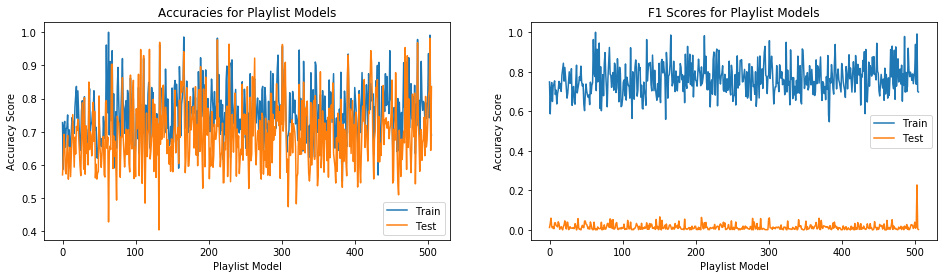

In [217]:
fig, ax = plt.subplots(1,2, figsize=(16,4))

model_index = range(0, len(lr_models))
train_accuracies = [m["train_accuracy"] for m in lr_models]
test_accuracies = [m["test_accuracy"] for m in lr_models]
train_f1s = [m["train_f1"] for m in lr_models]
test_f1s = [m["test_f1"] for m in lr_models]

ax[0].plot(model_index, train_accuracies, label="Train")
ax[0].plot(model_index, test_accuracies, label="Test")
ax[0].set_title("Accuracies for Playlist Models")
ax[0].set_xlabel("Playlist Model")
ax[0].set_ylabel("Accuracy Score")
ax[0].legend()

ax[1].plot(model_index, train_f1s, label="Train")
ax[1].plot(model_index, test_f1s, label="Test")
ax[1].set_title("F1 Scores for Playlist Models")
ax[1].set_xlabel("Playlist Model")
ax[1].set_ylabel("Accuracy Score")
ax[1].legend()

# This demonstrates the clear inability for logistic regression to classify songs as to whether or not they belong
# within a playlist

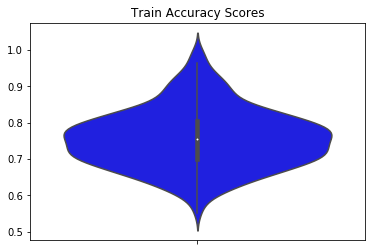

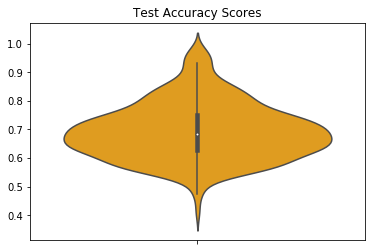

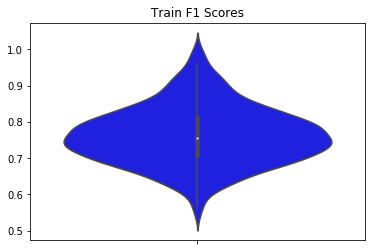

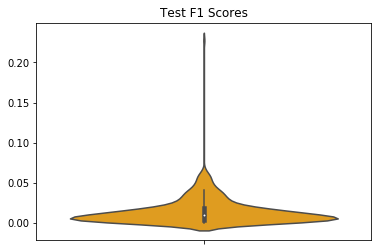

In [295]:
sns.violinplot(y=[train_accuracies], color="Blue")
plt.title("Train Accuracy Scores")
plt.show()
sns.violinplot(y=[test_accuracies], color="orange")
plt.title("Test Accuracy Scores")
plt.show()

sns.violinplot(y=[train_f1s], color="blue")
plt.title("Train F1 Scores")
plt.show()

sns.violinplot(y=[test_f1s], color="orange")
plt.title("Test F1 Scores")
plt.show()


In [281]:
import math

def predictor_t_values(X_train, y_train, playlists):
    """
    Returns top 10 t-values, indicating which items
    provide the most signal as a predictor between the
    two types.
    
    Takes in the statistics of two types as a parameter.
    """
    predictors = pd.DataFrame(columns = X_COLUMNS)    
    with tqdm_notebook(total=len(playlists)) as pbar:
        for playlist_index in playlists:
            training_set = pd.concat([X_train, y_train], axis=1)

            # First, grab all items that are in a given playlist and add that to the
            # final downsampled set
            in_playlist = training_set[training_set[playlist_index] == 1]
            not_in_playlist = training_set[training_set[playlist_index] == 0].sample(len(in_playlist))

            downsampled = pd.concat([in_playlist, not_in_playlist])

            type_1 = downsampled[downsampled[playlist] == 1]
            type_2 = downsampled[downsampled[playlist] == 0]

            signal = np.abs(type_1.mean() - type_2.mean())
            type_1_noise = (type_1.var()) / type_1.count()
            type_2_noise = (type_2.var()) / type_2.count()
            noise = np.sqrt(type_1_noise + type_2_noise)
            t_values = signal / noise
            results = t_values.sort_values(ascending=False).drop(playlists).to_dict()
            predictors = predictors.append(results, ignore_index=True)
            pbar.update(1)
    return predictors

predictor_t_values = get_top_10_tvalues(X_train_df, y_train_df, playlist_indices)


In [282]:
predictor_t_values.mean()

danceability        2.458528
energy              2.907320
key                 2.908370
loudness            2.705092
mode                4.830486
speechiness         4.624056
acousticness        3.285192
instrumentalness    4.049592
liveness            3.322635
valence             2.510551
tempo               4.003240
duration_ms         2.152537
time_signature      2.490433
dtype: float64